# 10 minutes CLIMADA

This is a brief introduction to CLIMADA that showcases CLIMADA's key building block, the impact calculation. For more details and features of the impact calculation, please check out the more detailed [CLIMADA Overview](../tutorial/1_main_climada.ipynb). TBDnaming

## Key ingredients in a CLIMADA impact calculation

For CLIMADA's impact calculation, we have to specify the following ingredients:
- **Hazard**: The hazard object entails event-based and spatially-resolved information of the intensity of a natural hazard. It contains a probabilistic event set, meaning that is a set of several events, each of which is associated to a frequency corresponding to the estimated probability of the occurence of the event.
-  **Exposure**: The exposure information provides the location and the number and/or value of objects (e.g., humans, buildings, ecosystems) that are exposed to the hazard.
- **Vulnerability**: The impact or vunerability function models the average impact that is expected for a given exposure value and given hazard intensity.

## Exemplary impact calculation

We exemplify the impact calculation and its key ingredients with an analysis of the risk of tropical cyclones on several assets in Florida.


### Hazard objects

First, we read a demo hazard file that includes information about several tropical cyclone events. 

In [ ]:
from climada.hazard import Hazard
from climada.util import HAZ_DEMO_H5

haz = Hazard.from_hdf5(HAZ_DEMO_H5)

# to hide the warnings
import warnings

warnings.filterwarnings("ignore")

We can infer some information from the Hazard object. The central piece of the hazard object is a sparse matrix at `haz.intensity` that contains the hazard intensity values for each event (axis 0) and each location (axis 1). 

In [22]:
print(
    f"The hazard object contains {haz.intensity.shape[0]} events. \n"
    f"The maximal intensity contained in the Hazard object is {haz.intensity.max():.2f} {haz.units}. \n"
    f"The first event was observed in a time series of {int(1/haz.frequency[0])} {haz.frequency_unit[2:]}s, \n"
    f"which is why CLIMADA estimates an annual probability of {haz.frequency[0]:.4f} for the occurence of this event."
)

The hazard object contains 216 events. 
The maximal intensity contained in the Hazard object is 72.75 m/s. 
The first event was observed in a time series of 185 years, 
which is why CLIMADA estimates an annual probability of 0.0054 for the occurence of this event.


The probabilistic event set and its single events can be plotted. For instance, below we plot maximal intensity per grid point over the whole event set.

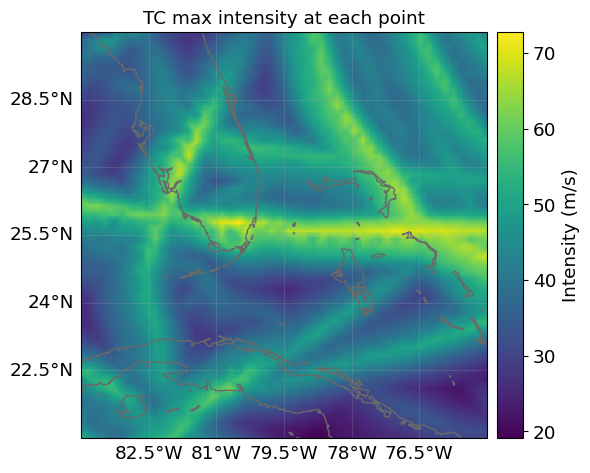

In [23]:
haz.plot_intensity(0, figsize=(6, 6));

### Exposure objects
Now, we read a demo expopure file containing the location and value of a number of exposed assets in Florida.

In [24]:
from climada.entity import Exposures
from climada.util.constants import EXP_DEMO_H5

exp = Exposures.from_hdf5(EXP_DEMO_H5)

2025-01-21 15:38:13,269 - climada.entity.exposures.base - INFO - Reading /Users/vgebhart/climada/demo/data/exp_demo_today.h5


We can print some basic information about the exposure object. The central information of the exposure object is contained in a geopandas.GeoDataFrame at `exp.gdf`.

In [2]:
print(
    f"In the exposure object, a total amount of {exp.value_unit} {exp.gdf.value.sum() / 1_000_000_000:.2f}B"
    f" is distributed among {exp.gdf.shape[0]} points."
)

In the exposure object, a total amount of USD 657.05B is distributed among 50 points.


We can plot the different exposure points on a map.

2025-01-21 15:39:38,249 - climada.entity.exposures.base - INFO - Setting latitude and longitude attributes.
2025-01-21 15:39:38,498 - climada.entity.exposures.base - INFO - Setting latitude and longitude attributes.


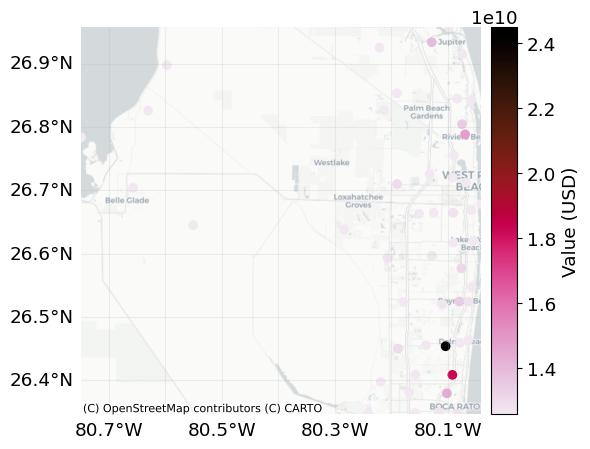

In [25]:
exp.plot_basemap(figsize=(6, 6));

### Impact Functions

To model the impact to the exposure that is caused by the hazard, CLIMADA makes use of an impact function. This function relates both percentage of assets affected (PAA, red line below) and the mean damage degree (MDD, blue line below), to the hazard intensity. The multiplication of PAA and MDD result in the mean damage ratio (MDR, black dashed line below), that relates the hazard intensity to corresponding relative impact values. Finally, a multiplication with the exposure values results in the total impact.

Below, we read and plot a standard impact function for tropical cyclones.

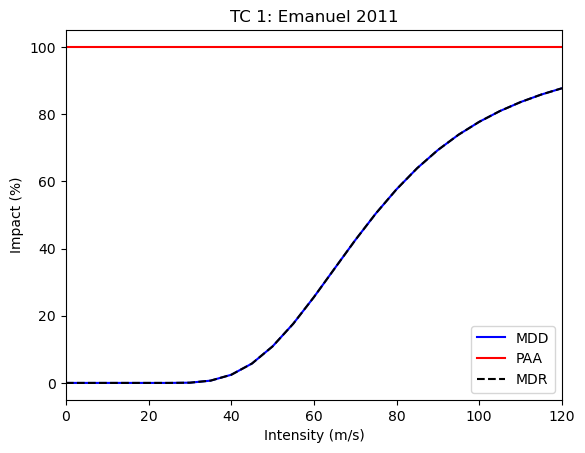

In [26]:
from climada.entity import ImpactFuncSet, ImpfTropCyclone

impf_tc = ImpfTropCyclone.from_emanuel_usa()
impf_set = ImpactFuncSet([impf_tc])
impf_set.plot();

### Impact calculation 

Having defined hazard, exposure, and impact function, we can finally perform the impact calcuation. 


In [27]:
from climada.engine import ImpactCalc

imp = ImpactCalc(exp, impf_set, haz).impact(save_mat=True)

2025-01-21 15:43:22,682 - climada.entity.exposures.base - INFO - Matching 50 exposures with 2500 centroids.
2025-01-21 15:43:22,683 - climada.util.coordinates - INFO - No exact centroid match found. Reprojecting coordinates to nearest neighbor closer than the threshold = 100
2025-01-21 15:43:22,686 - climada.engine.impact_calc - INFO - Calculating impact for 250 assets (>0) and 216 events.
2025-01-21 15:43:22,687 - climada.engine.impact_calc - INFO - cover and/or deductible columns detected, going to calculate insured impact


The Impact object contains the results of the impact calculation (including event- and location-wise impact information when `save_mat=True`).

In [9]:
print(
    f"The total expected annual impact over all exposure points is {imp.unit} {imp.aai_agg / 1_000_000:.2f} M. \n"
    f"The largest estimated single-event impact is {imp.unit} {max(imp.at_event) / 1_000_000_000:.2f} B. \n"
    f"The largest expected annual impact for a single location is {imp.unit} {max(imp.eai_exp) / 1_000_000:.2f} M. \n"
)

The total expected annual impact over all exposure points is USD 288.90 M. 
The largest estimated single-event impact is USD 20.96 B. 
The largest expected annual impact for a single location is USD 9.58 M. 



Several visualizations of impact objects are available. For instance, we can plot the expected annual impact per location on a map.

2025-01-21 15:44:16,514 - climada.util.coordinates - INFO - Setting geometry points.
2025-01-21 15:44:16,518 - climada.entity.exposures.base - INFO - Setting latitude and longitude attributes.
2025-01-21 15:44:16,771 - climada.entity.exposures.base - INFO - Setting latitude and longitude attributes.


<GeoAxes: title={'center': 'Expected annual impact'}>

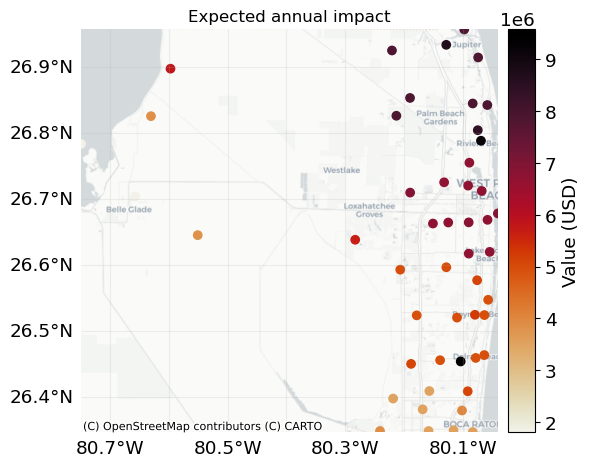

In [28]:
imp.plot_basemap_eai_exposure(figsize=(6, 6))

## Further CLIMADA features

CLIMADA offers several additional features and modules that complement its basic impact and risk calculation, among which are
- uncertainty and sensitivity analysis
- adaptation option appraisal and cost benefit analysis
- several tools for providing hazard objects such as tropical cyclones, floods, or winter storms; and exposure objects such as Litpop, or open street maps
- impact function calibration methods

We end this introduction with a simple adaptation measure analysis. 

### Adaptation measure analysis

Consider a simple adaptation measure that results in a 10% decrease in the percentage of affected assets (PAA) decreases and a 20% decrease in the mean damage degree (MDD). We apply this measure and recompute the impact.

In [31]:
from climada.entity.measures import Measure

meas = Measure(haz_type="TC", paa_impact=(0.9, 0), mdd_impact=(0.8, 0))

new_exp, new_impfs, new_haz = meas.apply(exp, impf_set, haz)
new_imp = ImpactCalc(new_exp, new_impfs, new_haz).impact()

2025-01-21 15:49:48,642 - climada.entity.exposures.base - INFO - Exposures matching centroids already found for TC
2025-01-21 15:49:48,643 - climada.entity.exposures.base - INFO - Existing centroids will be overwritten for TC
2025-01-21 15:49:48,643 - climada.entity.exposures.base - INFO - Matching 50 exposures with 2500 centroids.
2025-01-21 15:49:48,645 - climada.util.coordinates - INFO - No exact centroid match found. Reprojecting coordinates to nearest neighbor closer than the threshold = 100
2025-01-21 15:49:48,648 - climada.engine.impact_calc - INFO - Calculating impact for 250 assets (>0) and 216 events.
2025-01-21 15:49:48,648 - climada.engine.impact_calc - INFO - cover and/or deductible columns detected, going to calculate insured impact


To analyze the effect of the adaptation measure, we can, for instance, plot the impact exceedance frequency curves that describe, according to the given data, how frequent different impacts thresholds are expected to be exceeded.

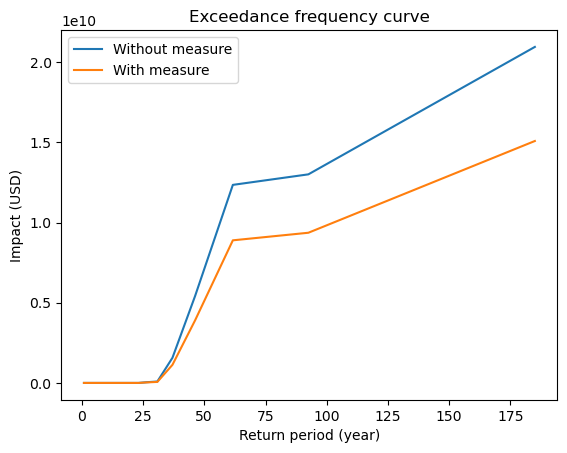

In [32]:
ax = imp.calc_freq_curve().plot(label="Without measure")
new_imp.calc_freq_curve().plot(axis=ax, label="With measure")
ax.legend()